# CompasDataset Exploration

Amrita Acharya, Dianne Caravela, Elisabeth Nesmith, Emma Kornberg, Eunice Kim
with Women At the Table

In [42]:
##Install packages 
!pip install aif360;
!pip install fairlearn;
!pip install 'aif360[AdversarialDebiasing]'

In [43]:
##Install packages to fetch data 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
from aif360.algorithms.inprocessing import MetaFairClassifier

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, average_odds_difference
from aif360.sklearn.metrics import generalized_fnr, difference, statistical_parity_difference, equal_opportunity_difference, generalized_entropy_error

from IPython.display import Markdown, display

In [44]:
#Data = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv")
#Data.head()

In [45]:
#@title Confusion matrix and Visualisation plots, creating function for later 

# Function for visualising the confusion matrix and other statistics
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf_matrix, model):
  group_names = ["True Negative","False Positive","False Negative","True Positive"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  group_labels = ["{}\n".format(value) for value in group_names]
  group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])


  # add more statistics
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
      accuracy,precision,recall,f1_score)


  categories=["Low score", "High score"]
  sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap='Purples',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  plt.title(f"Confusion matrix and statistics for the {model} model");

## defining function for displaying metrics of training and test data by sex 
def metrics_per_group(y_test, y_pred):
	# y true per group
	y_test_male = y_test.loc[y_test.index.get_level_values(1) == 1]
	y_test_female = y_test.loc[y_test.index.get_level_values(1) == 0]

	# y_pred per group
	y_pred_male = y_pred[y_test.index.get_level_values(1) == 1]
	y_pred_female = y_pred[y_test.index.get_level_values(1) == 0]

	# metrics
	scores = []
	scores.append(accuracy_score(y_test, y_pred))
	scores.append(recall_score(y_test, y_pred))
	scores.append(precision_score(y_test, y_pred))

	scores.append(accuracy_score(y_test_female, y_pred_female))
	scores.append(recall_score(y_test_female, y_pred_female))
	scores.append(precision_score(y_test_female, y_pred_female))

	scores.append(accuracy_score(y_test_male, y_pred_male))
	scores.append(recall_score(y_test_male, y_pred_male))
	scores.append(precision_score(y_test_male, y_pred_male))

	attribute = ["all"]*3 + ["female"] *3 + ["male"] *3
	metric = ["accuracy", "recall", "precision"] * 3
	  
	# dictionary of lists 
	dict = {'gender': attribute, 'metrics': metric, 'score': scores} 
	    
	df = pd.DataFrame(dict)

	sns.barplot(x = "metrics", y = "score", hue = "gender", data = df, palette = ['#dfcd1a', '#9d0677', '#236c48'])
	plt.title("Performance metrics by groups")
 

def plot_fair_metrics(fair_metrics_mitigated, model): 
  cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'generalized_entropy']
  obj_fairness = [[0,0,1]]

  # row for objectives    
  fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
      
  # row for baseline model
  fair_metrics.loc['Baseline Model'] = [stat_par_diff, eq_opp_diff, gen_entr_error]

  # row for mitigated bias
  fair_metrics.loc[model] = fair_metrics_mitigated


  metrics_len = len(cols)


  fig, ax = plt.subplots(figsize=(20,4), ncols=metrics_len, nrows=1)

  plt.subplots_adjust(
      left    =  0.125, 
      bottom  =  0.1, 
      right   =  0.9, 
      top     =  0.9, 
      wspace  =  .5, 
      hspace  =  1.1
  )

  y_title_margin = 1.2

  plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
  sns.set(style="dark")

  cols = fair_metrics.columns.values
  obj = fair_metrics.loc['objective']
  size_rect = [0.2,0.2,0.2,0.4,0.25]
  rect = [-0.1,-0.1,-0.1,0.8,0]
  bottom = [-1,-1,-1,0,0]
  top = [1,1,1,2,1]
  bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

  for i in range(0,metrics_len):
      plt.subplot(1, metrics_len, i+1)
      ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
      
      for j in range(0,len(fair_metrics)-1):
          a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
          marg = -0.2 if val < 0 else 0.1
          ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

      plt.ylim(bottom[i], top[i])
      plt.setp(ax.patches, linewidth=0)
      ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
      plt.axhline(obj[i], color='black', alpha=0.3)
      plt.title(cols[i])
      ax.set_ylabel('')    
      ax.set_xlabel('')

In [46]:
## In machine learning tasks, specifically with supervised learning, you have features and labels. 
## The features are the descriptive attributes (they are defined as X), and the label (y) is what you're attempting to predict or forecast

X, y = fetch_compas()
print(f'There are {X.shape[0]} entries and {X.shape[1]} features')
X.head()

There are 6167 entries and 10 features


,,,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc
id,sex,race,,,,,,,,,,
1,Male,Other,Male,69,Greater than 45,Other,0,0,0,0,F,Aggravated Assault w/Firearm
3,Male,African-American,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict
4,Male,African-American,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine
7,Male,Other,Male,44,25 - 45,Other,0,0,0,0,M,Battery
8,Male,Caucasian,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools


In [47]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [48]:
# set target class to 0/1
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

# Exploratory Data Analysis

In [49]:
df_viz = X.copy()
df_viz['sex'] = X['sex'].replace({1.0: 'Male', 0.0: 'Female'})
df_viz['c_charge_degree'] = y.replace({1:'M', 0: 'F'})
df_viz.index = df_viz.index.droplevel('sex')

purple = '#9d0677'
green = '#30875c'
workshop_palette = [purple, green]

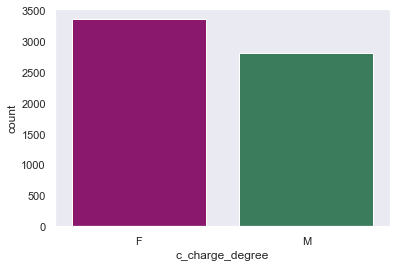

In [50]:
sns.countplot(x='c_charge_degree', data=df_viz, palette=workshop_palette)

Ethnicity Plot

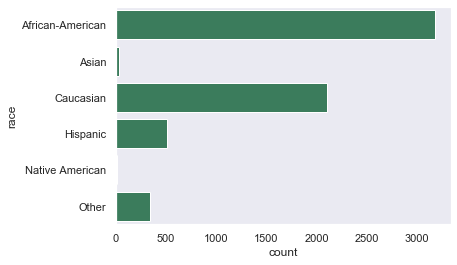

In [51]:
sns.countplot(y="race", data=df_viz, palette=["#30875c"])

In [52]:
#Ethnicity by Gender

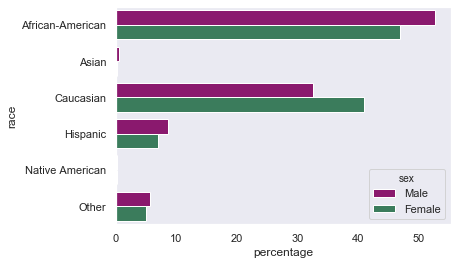

In [53]:
race_counts = (df_viz.groupby(['sex'])['race']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('race'))
p = sns.barplot(y="race", x="percentage", hue="sex", data=race_counts, palette=workshop_palette)

Age Category Distribution by Sex

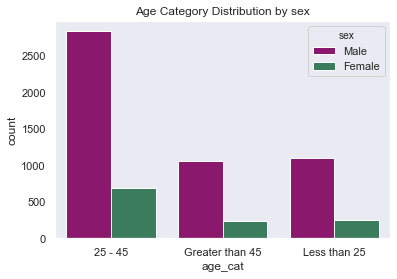

In [54]:
by_sex = sns.countplot(x="age_cat", hue="sex", data=df_viz, palette=workshop_palette)

plt.title('Age Category Distribution by sex')
plt.show()

# Baseline Metrics

In [55]:
##create dummies, 25% test, 75% train 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)

# one-hoy encode the categorical features
data_preproc = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.dtypes == 'category'))

X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index=X_test.index)

# to save the information for the column names
pd.get_dummies(X).head()

,,,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Male,sex_Female,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,...,c_charge_desc_Video Voyeur-<24Y on Child >16,c_charge_desc_Viol Injunct Domestic Violence,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_arrest case no charge
id,sex,race,,,,,,,,,,,,,,,,,,,,,
0,0,5,69,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,34,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,24,0,0,1,4,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,5,44,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,41,0,0,0,14,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Try different classification function, try different parameters (look at other functions of logistic regression) , analyze the coefficients, understanding the metrics more in depth and creating more understanding plots. Logistic regressioncv

Sprint 2 Deliverable: 
Analysis answering questions/understanding the subgroups of the data 
Find correlation between features and target variables (create plots) i.e.- Race and age 
Accurate baseline model that performs well on the true values 
Write up about what we understood on the two sides of the argument 

In [56]:
from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score

lr = LogisticRegression(solver='lbfgs')
reg = lr.fit(X_train, y_train)
y_pred = reg.predict(X_test)

acc_base = accuracy_score(y_test, y_pred)
print(f'[Baseline] The test accuracy of the algorithm is: {acc_base: .2%}')

[Baseline] The test accuracy of the algorithm is:  60.77%


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Confusion Matrix

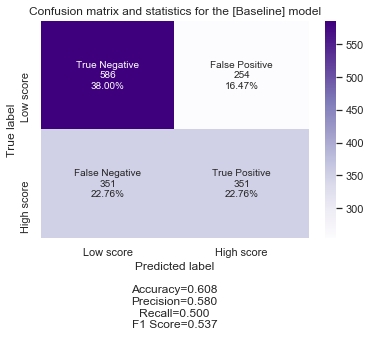

In [57]:
##Sex predicting score 
##Look at 2nd column of matrix for precision 
##2nd row of matrix for recall 
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, "[Baseline]")

The true positive accuracy is 22.76%, understand what changes need to be made for the model 

Precision and Recall are relatively similar and accuracy is high at 0.6. 

Precision: What proportion of positive identifications was actually correct?
When the model predicts a high score, it is correct 58% of the time. 
Recall: What proportion of actual positives was identified correctly?
The model identifies 50% of all high scores. 

Performance Metrics

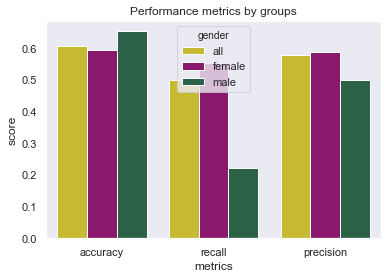

In [58]:
metrics_per_group(y_test, y_pred)

Statistical Parity Difference Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. It essentially equalizes the outcomes across the protected and non-protected groups.

In [59]:
stat_par_diff = statistical_parity_difference(y_test, prot_attr='sex')

print(f'[Baseline] The statistical parity difference is {stat_par_diff: .2}')

[Baseline] The statistical parity difference is  0.14


The difference between the rate of favorable outcomes received by the unprivileged group to the privileged group is 0.14. The value is positive and high, indicating that it is favorable for the unprivileged group. 

Generalized entropy error Generalized entropy index is proposed as a unified individual and group fairness measure. It measures the inequality in benefit allocation for individuals.
A value of 0 implies perfect fairness.
Fairness is indicated by lower scores, higher scores are problematic

In [60]:
gen_entr_error = generalized_entropy_error(y_test, y_pred, alpha=1)

print(f'[Baseline] The generalized entropy error is {gen_entr_error: .2}')

[Baseline] The generalized entropy error is  0.31


This is a high entropy value, indicating that using this individual fairness metric the model is very unfair. 

Equal Opportunity Difference This metric is computed as the difference of true positive rates between the unprivileged and the privileged groups. The true positive rate is the ratio of true positives to the total number of actual positives for a given group.
The ideal value is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group.

In [61]:
##
eq_opp_diff = equal_opportunity_difference(y_test, y_pred, prot_attr='sex')

print(f'[Baseline] The equal opportunity difference is {eq_opp_diff: .2}')

[Baseline] The equal opportunity difference is  0.33


This value implies that the model benefits the unprivileged group. 

Fairness Metrics

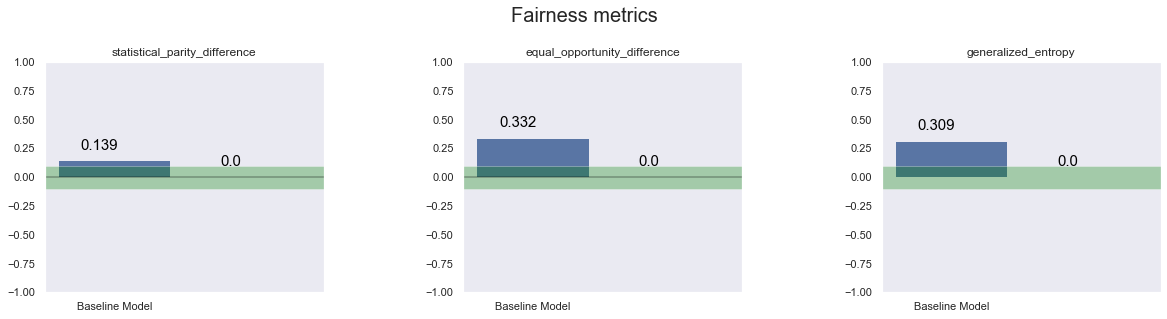

In [62]:
plot_fair_metrics([0, 0, 0], '')

This metrics plot shows only the baseline model, as we have not yet corrected for fairness. The value we are most concerned about correcting is the generalized entropy error. However, we know this will yielf a tradeoff with the group metrics. 

# Pre-Processing Approach

In [63]:
##Choosing logistic, can choose other models 
##analyze coefficients to understand the which parts play a role in the analysis su
lr = LogisticRegression(solver='lbfgs')
rew = ReweighingMeta(estimator=lr, reweigher=Reweighing('sex'))
rew.fit(X_train, y_train)
y_pred_REW = rew.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [64]:
acc_REW = accuracy_score(y_test, y_pred_REW)
print(f'[Reweighting] The test accuracy of the algorithm is: {acc_REW: .2%}')

[Reweighting] The test accuracy of the algorithm is:  58.88%


Confusion Matrix (Reweighting) 

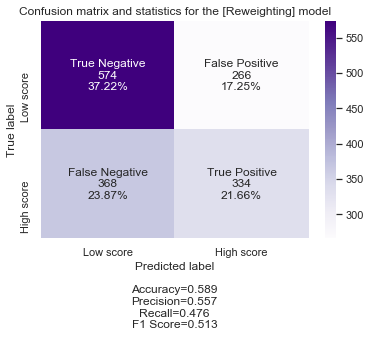

In [65]:
cf_matrix = confusion_matrix(y_test, y_pred_REW)
make_confusion_matrix(cf_matrix, "[Reweighting]")

These precision, recall and accuracy values are not too different than the baseline model. They are only slightly lower than the original values. 

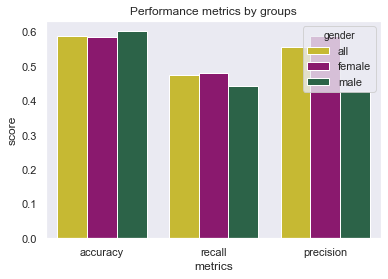

In [66]:
metrics_per_group(y_test, y_pred_REW)

In [67]:
stat_par_diff_RW = statistical_parity_difference(y_test, y_pred_REW, prot_attr='sex')
print(f'[Reweighting] The statistical parity difference is {stat_par_diff_RW: .2}')

[Reweighting] The statistical parity difference is  0.04


The value is close to 0, and implying higher benefit to the unprivileged group. 

In [68]:
# rebalance the dataset using the algorithm in the paper
# train the model
# evalute model on the same metrics
eq_opp_diff_RW = equal_opportunity_difference(y_test, y_pred_REW, prot_attr='sex')

print(f'[Reweighting] The equal opportunity difference is {eq_opp_diff_RW: .2}')

[Reweighting] The equal opportunity difference is  0.04


In [ ]:
The value is close to 0, and implying higher benefit to the unprivileged group. 

In [69]:
gen_entr_error_RW = generalized_entropy_error(y_test, y_pred_REW, alpha=1)


print(f'[Reweighting] The generalized entropy error is {gen_entr_error_RW: .2}')

[Reweighting] The generalized entropy error is  0.32


The generalized entropy error is still high, as it only went down by 0.01. Therefore, the model is still far from individual fairness

Fairness Metrics

When we reweigh the sensitive variables the model gets better for group metrics, parity and equal opportunity difference, going down to 0.04 and implying benefit to the unprivileged group. However, the individual metric gets worse, going up to 0.325, implying that the model is still far from fair. 

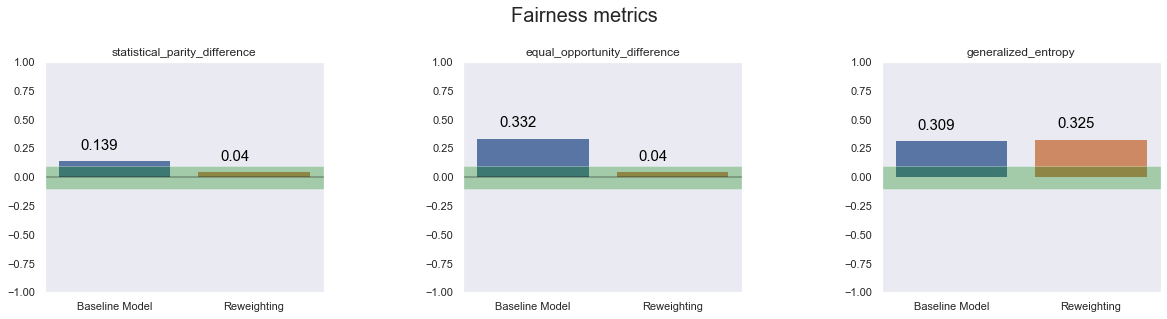

In [70]:
plot_fair_metrics([stat_par_diff_RW, eq_opp_diff_RW, gen_entr_error_RW], 'Reweighting')

# Post-Processing: Control Sets

We could not get our in-processing methods to work, which would have corrected the learning algorithm. We instead jump to post-processing technique where transforms model outputs in order to correct fairness later on. 

In [71]:
# dataset
# train model
# add the reject opinion based classification algorithm
# evaluate on fairness metrics

from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta

pp = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567)
ceo = PostProcessingMeta(estimator=lr, postprocessor=pp, random_state=1234567)
ceo.fit(X_train, y_train)
y_pred_CEO = ceo.predict(X_test)
y_proba_CEO = ceo.predict_proba(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [72]:
acc_CEO = accuracy_score(y_test, y_pred_CEO)
print(f'[Calibrated Equalized Odds] The test accuracy of the algorithm is: {acc_CEO: .2%}')

[Calibrated Equalized Odds] The test accuracy of the algorithm is:  54.28%


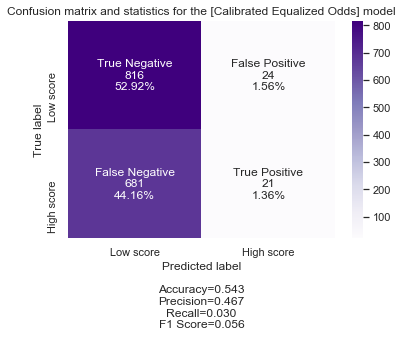

In [73]:
cf_matrix = confusion_matrix(y_test, y_pred_CEO)
make_confusion_matrix(cf_matrix, "[Calibrated Equalized Odds]")

We can see that we have a very low recall rate, demonstrating that of the positive guesses, 3% are actually correct. 

In [74]:
stat_par_diff_CEO = statistical_parity_difference(y_test, y_pred_CEO, prot_attr='sex')

print(f'[Calibrated Equalized Odds] The statistical parity difference is {stat_par_diff_CEO: .2}')

[Calibrated Equalized Odds] The statistical parity difference is -0.14


In [75]:
eq_opp_diff_CEO = equal_opportunity_difference(y_test, y_pred_CEO, prot_attr='sex')

print(f'[Calibrated Equalized Odds] The equal opportunity difference is {eq_opp_diff_CEO: .2}')

[Calibrated Equalized Odds] The equal opportunity difference is -0.19


In [76]:
gen_entr_error_CEO = generalized_entropy_error(y_test, y_pred_CEO, alpha=1)


print(f'[Calibrated Equalized Odds] The generalized entropy error is {gen_entr_error_CEO: .2}')

[Calibrated Equalized Odds] The generalized entropy error is  0.59


The generalized entropy error gets much higher which means that compared to the baseline this approach gets further away from fairness. 

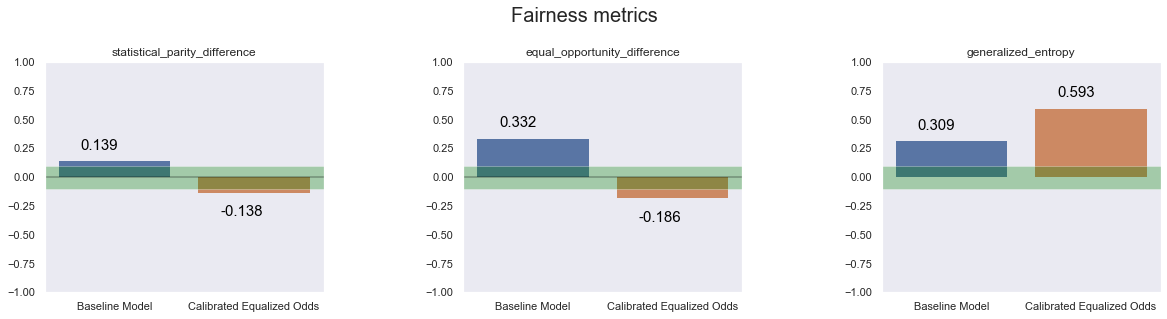

In [77]:
plot_fair_metrics([stat_par_diff_CEO, eq_opp_diff_CEO, gen_entr_error_CEO], 'Calibrated Equalized Odds')

All three metrics get much worse. The group metrics become negative and further from 0, implying a greater benefit to the privileged group. The individual metric also gets worse, almost doubling, to indicate that the post-processing method makes the model more unfair. 